In [1]:
# detector_construction.ipynb
# Authors: Stephan Meighen-Berger
# Example how to build a detector

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
# Hebe imports
from hebe import HEBE, config
from jax.config import config as jconfig

In [3]:
# Jax stuff
jconfig.update("jax_enable_x64", True)

In [4]:
# Here we are generating evenly spaced lines in a circle, e.g. KM3NeT
def sunflower(n, alpha=0, geodesic=False):
    points = []
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    angle_stride = 360 * phi if geodesic else 2 * np.pi / phi ** 2
    b = round(alpha * np.sqrt(n))  # number of boundary points
    for k in range(1, n + 1):
        r = radius(k, n, b)
        theta = k * angle_stride
        points.append((r * np.cos(theta), r * np.sin(theta)))
    return np.array(points)

def radius(k, n, b):
    if k > n - b:
        return 1.0
    else:
        return np.sqrt(k - 0.5) / np.sqrt(n - (b + 1) / 2)

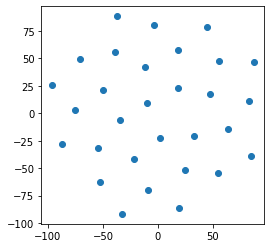

In [5]:
# Plotting points
fig, ax = plt.subplots()
points = sunflower(30, alpha=0.2, geodesic=False) * 100.
xs = [point[0] for point in points]
ys = [point[1] for point in points]
ax.scatter(xs, ys)
ax.set_aspect('equal') # display as square plot with equal axes
plt.show()

In [6]:
# Generating modules per line
# So inefficient
nz_list = []
dist_z_list = []
for line in points:
    nz_list.append(22)
    dist_z_list.append(9.09)
# Combined array
detector_specs = np.array([
    points[:, 0],
    points[:, 1],
    nz_list,
    dist_z_list
])
np.savetxt('../hebe/data/custom.txt', detector_specs)

In [7]:
# HEBE Config
config["general"]["random state seed"] = 1337
config["general"]["meta_name"] = 'meta_data_%d' % 1337
config['general']['clean up'] = False
config['lepton injector']['simulation']['output name'] = "./output/custom_%d_output_LI.h5" % 1337
config['photon propagator']['storage location'] = './output/custom_%d_' % 1337
config['lepton injector']['simulation']['nevents'] = 100
config['lepton injector']['simulation']['minimal energy'] = 1e1
config['lepton injector']['simulation']['maximal energy'] = 1e2
config['lepton injector']['simulation']["injection radius"] = 150
config['lepton injector']['simulation']["endcap length"] = 200
config['lepton injector']['simulation']["cylinder radius"] = 150
config['lepton injector']['simulation']["cylinder height"] = 400
config['detector']['injection offset'] = [0., 0., 0]
config['photon propagator']['name'] = 'olympus'
config["detector"]['new detector'] = True
config["detector"]['detector specs file'] = '../hebe/data/custom.txt'
config["detector"]["file name"] = '../hebe/data/custom-f2k'
hebe = HEBE()

-------------------------------------------
Dumping config file
Finished dump
-------------------------------------------
-------------------------------------------
Setting up the detector
Starting up the detector handler
Building a new detector
Finished the detector
-------------------------------------------
Setting up leptopn propagation
Using proposal
The proposal version is 7.3.1
This assumes a homogeneous medium!
Using new setup
----------------------------------------------------
Setting up proposal
Finished setup
----------------------------------------------------
Finished the lepton propagator
-------------------------------------------
-------------------------------------------
Setting up photon propagation
--------------------------------------------
Constructing the photon propagator
Using olympus
Setting up the medium
Finished the medium
-------------------------------------------------------
Setting up the photon generator
Finished the photon generator
----------------

In [8]:
hebe.sim()

-------------------------------------------
Setting up and running LI
Injecting
Setting up the LI
Fetching parameters and setting paths
Setting the simulation parameters for the LI
Setting up the LI object
Setting injection parameters
Building the injection handler
Defining the earth model
Earth model location to use: /opt/LI/source/resources/earthparams/ With the model Planet
Planet earthparams/
Setting the seed
Defining the output location
Creating Controller
Finished LI, loading data
Finished loading
Creating the data set for further propagation
Using the full data set
Finished the data set
Injection simulations took 0.183792 seconds
-------------------------------------------
-------------------------------------------
-------------------------------------------
-------------------------------------------
Starting particle loop
-------------------------------
Starting set
Initializing Earth
Using... PREM... Standard Rock... 
Freezing ice
Executing Injectors
Note: LIC file already e

100%|██████████| 500/500 [39:07<00:00,  4.69s/it]  


-------------------------------
-------------------------------
Starting set


100%|██████████| 500/500 [48:06<00:00,  5.77s/it]


-------------------------------
Finished particle loop
-------------------------------------------
The simulation took 5234.298582 seconds
-------------------------------------------
-------------------------------------------
Results are stored in self.results
-------------------------------------------
Dumping results
Storing metadata file
Adding metadata
Finished new data file
Finished meta data file
Finished dump
Have a good day!
-------------------------------------------
-------------------------------------------


In [9]:
# Plotting
import awkward as ak
import numpy as np
import h5py
import pyarrow as pa
import pyarrow.parquet as pq
import json

In [10]:
# Truth fetcher
def truth_fetcher(filename: str):
    """ Fetches the true values from the injection file

    Parameters
    ----------
    filename : str
        File to load

    Returns
    -------
    truth : dict
        Dictionary containig the injection information
    """
    LI_raw = h5py.File(
        filename
    )
    final_states = {}
    for elem in config['run']['data sets']:
        if elem[0]:
            final_states[elem[1]] = (
                LI_raw[config['run']['group name']][elem[1]]
            )
    print('Finished loading')
    # Creating data set
    print('Creating the data set for further propagation')
    truth = {}
    for key in final_states.keys():
        print('-------------------------------')
        print('Starting set')
        truth[key] = []
        for event in final_states[key]:
            # Making sure the event id is okay:
            if event[1] in config['particles']['explicit']:
                event_id = event[1]
            else:
                event_id = config['particles']['replacement']
            pos = np.array(event[2])
            # Introducing an injection offset caused by the different
            # coordinate systems between LI and the t2k file.
            pos = pos + np.array(config['detector']['injection offset'])
            truth[key].append({
                "time": 0.,
                "theta": event[3][0],
                "phi": event[3][1],
                # TODO: This needs to be removed once the coordinate
                # systems match!
                "pos": pos,
                "energy": event[4],
                "particle_id": event_id,
                'length': config['lepton propagator']['track length'],
                'event id': event_id
            })
    return truth

In [11]:
set_id = '1337'
truth_dict = truth_fetcher('./output/custom_' + set_id + '_output_LI.h5')
config["detector"]["file name"] = '../hebe/data/custom-f2k-f2k'

Finished loading
Creating the data set for further propagation
-------------------------------
Starting set
-------------------------------
Starting set


In [12]:
results = ak.from_parquet(
    config['photon propagator']['storage location'] + 'final_1' + '.parquet'
)

In [13]:
config['plot']['zrange'] = [-500, 500]
config['plot']['xrange'] = [-200, 200]
config['plot']['yrange'] = [-200, 200]
hit_set = []
minimal_hits = 1
for id_event, event in enumerate(results):
    total_hits = sum([len(dom) for dom in event])
    if total_hits > minimal_hits:
        hit_set.append([truth_dict['final_1'][id_event], total_hits, event])
max_event = np.argmax([event[1] for event in hit_set])
dom_hits_list = []
for event in hit_set:
    counter = 0
    for dom in event[2]:
        if len(dom) > 0:
            counter += 1
    dom_hits_list.append(counter)
max_dom = np.argmax(dom_hits_list)
print("Fraction of useful events: %f" % (len(hit_set) / len(results)))
print(max_event)
print(max_dom)

Fraction of useful events: 0.506000
236
89


In [16]:
print('Most hits')
id_event = 236
hebe.event_plotting(
    hebe._det,
    hit_set[id_event][2]
)
print('Event ID')
print(id_event)
print('Hits')
print(sum([len(dom) for dom in hit_set[id_event][2]]))
print('Energy in GeV')
print(hit_set[id_event][0]['energy'])

Most hits


Event ID
236
Hits
19401
Energy in GeV
18.22827287802272
